In [283]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [285]:
#### Constants for Argon (in dimensionless units)
LENGTH_UNIT = 3.4e-10  # m
ENERGY_UNIT = 1.65e-21  # J
MASS_UNIT = 6.69e-26    # kg

# Derived constants
TIME_UNIT = LENGTH_UNIT * (MASS_UNIT / ENERGY_UNIT) ** 0.5  # s
VELOCITY_UNIT = (ENERGY_UNIT / MASS_UNIT) ** 0.5  # m/s
FORCE_UNIT = ENERGY_UNIT / LENGTH_UNIT  # N
CUT_OFF = 2.5 * LENGTH_UNIT / LENGTH_UNIT  # Cutoff radius in dimensionless units

# Constants for Argon (in reduced units)
sigma = LENGTH_UNIT / LENGTH_UNIT  # Lennard-Jones diameter (dimensionless)
epsilon = ENERGY_UNIT / ENERGY_UNIT  # Lennard-Jones depth (dimensionless)

# Simulation parameters
N_PARTICLES = 16    # Number of particles
BOX_SIZE = 10.0        # Box size in dimensionless units
DT = 0.005              # Time step in dimensionless units
TOTAL_TIME = 5      # Total simulation time in dimensionless units
STEPS = int(TOTAL_TIME / DT)  # Total number of steps

In [287]:
# Initialize positions on a regular grid
positions = np.zeros((N_PARTICLES, 2))
grid_size = int(np.sqrt(N_PARTICLES))
for i in range(grid_size):
    for j in range(grid_size):
        if i * grid_size + j < N_PARTICLES:
            positions[i * grid_size + j] = [i*(BOX_SIZE / grid_size), j * (BOX_SIZE / grid_size)]
initial_positions=np.copy(positions)

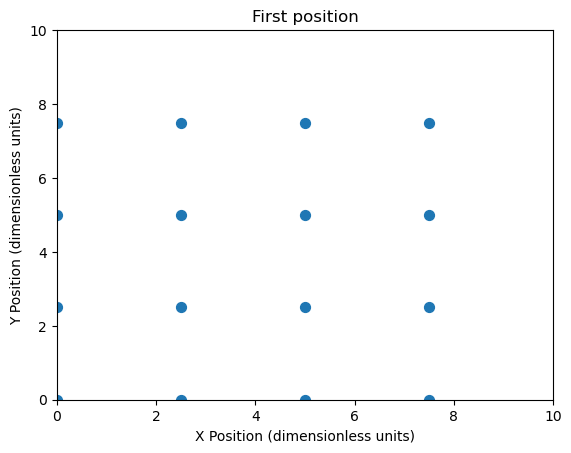

In [289]:
# Visualization of particle first position
fig, ax = plt.subplots()
ax.set_xlim(0, BOX_SIZE)
ax.set_ylim(0, BOX_SIZE)
scat = ax.scatter(positions[:, 0], positions[:, 1], s=50)

plt.title("First position")
plt.xlabel("X Position (dimensionless units)")
plt.ylabel("Y Position (dimensionless units)")
plt.savefig("avalie.png")
plt.show()

In [293]:
# Initialize random velocities
np.random.seed(42)  # For reproducibility
velocities = np.random.rand(N_PARTICLES, 2) - 0.5


# Function to compute forces based on Lennard-Jones potential
def compute_forces(positions):
    forces = np.zeros_like(positions)
    for i in range(N_PARTICLES):
        for j in range(i + 1, N_PARTICLES):
            r_ij = positions[i] - positions[j]
            r_ij -= np.round(r_ij / BOX_SIZE) * BOX_SIZE  # Periodic boundary conditions
            r = np.linalg.norm(r_ij)
            if r < CUT_OFF:
                f = 48  *(1/r**14 - 0.5/r**8)*  r_ij
                forces[i] += f
                forces[j] -= f
    return forces

def update_positions_and_velocities(positions, velocities):
    forces = compute_forces(positions)
    
    # Update positions using Verlet's method
    positions += velocities * DT + 0.5 * forces * DT**2

    # Update velocities
    new_forces = compute_forces(positions)
    velocities += 0.5 * (forces + new_forces) * DT

    # Periodic boundary conditions
    positions %= BOX_SIZE
    return positions, velocities

def calculate_Energies_Temperature (positions, velocities):
    # Calculate total energy
    kinetic_energy = 0.5 * np.sum(velocities**2)
    temperature = kinetic_energy / (N_PARTICLES * 1.5)  # temperature calculation based on degrees of freedom
    # calculationg potential energy
    potential_energy = 0.0
    for i in range(N_PARTICLES):
        for j in range(i + 1, N_PARTICLES):
            r_ij = positions[i] - positions[j]
            r_ij -= np.round(r_ij / BOX_SIZE) * BOX_SIZE
            r = np.linalg.norm(r_ij)
            if r < CUT_OFF:
                potential_energy += 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6)
                    
    total_energy = kinetic_energy + potential_energy      
    return total_energy,kinetic_energy,potential_energy,temperature

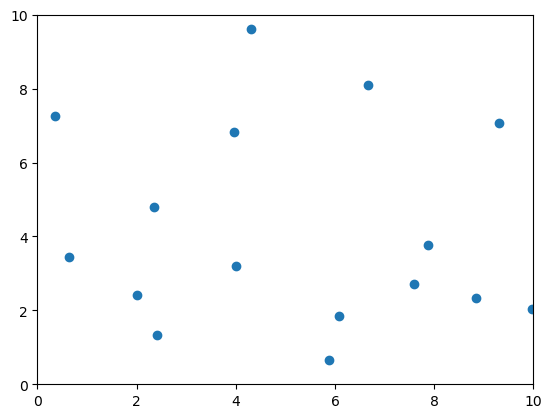

In [264]:
# video of positions 

# Set up the figure and axis for animation
fig, ax = plt.subplots()
sc = ax.scatter(positions[:, 0], positions[:, 1])
ax.set_xlim(0, BOX_SIZE)
ax.set_ylim(0, BOX_SIZE)

def init():
    sc.set_offsets(initial_positions)  # Ensure it's a 2D array
    return sc,

def update(frame):
    global positions, velocities
    positions,velocities=update_positions_and_velocities(positions, velocities) 
    sc.set_offsets(positions)
    return sc,


#ani = FuncAnimation(fig, update,init_func=init, frames=STEPS, blit=True)
ani = FuncAnimation(fig, update, frames=STEPS,init_func=init, blit=True)
# Save the animation as a GIF file using Pillow
ani.save('particle_simulation.gif', writer='pillow', fps=10)
plt.show()

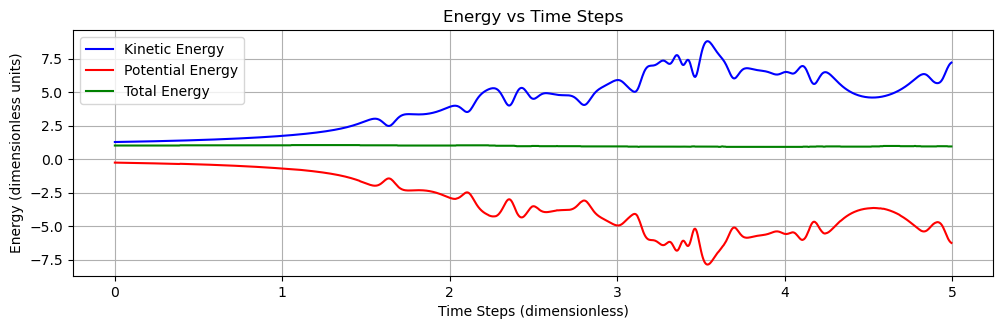

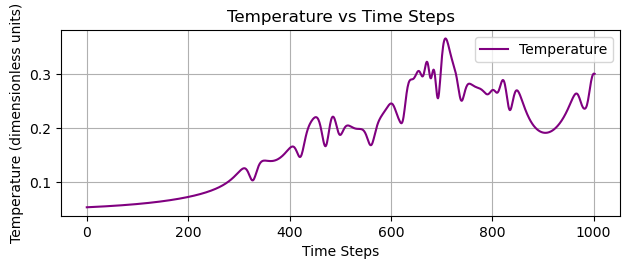

In [295]:
# Main simulation loop
kinetic_energies = []
potential_energies = []
total_energies = []
temperature = []

for step in range(STEPS):
    positions,velocities=update_positions_and_velocities(positions, velocities) 
    total_energy,kinetic_energy,potential_energy,temperatur=calculate_Energies_Temperature (positions, velocities)
    kinetic_energies.append(kinetic_energy)
    potential_energies.append(potential_energy)
    total_energies.append(total_energy)
    temperature.append(temperature)
    
    
# Plotting energy vs time steps
time_steps = np.arange(STEPS) * DT

plt.figure(figsize=(10, 6))
# Energy plot                   
plt.subplot(2, 1, 1)                   
plt.plot(time_steps, kinetic_energies, label='Kinetic Energy', color='blue')
plt.plot(time_steps, potential_energies, label='Potential Energy', color='red')
plt.plot(time_steps, total_energies, label='Total Energy', color='green')
plt.title('Energy vs Time Steps')
plt.xlabel('Time Steps (dimensionless)')
plt.ylabel('Energy (dimensionless units)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("energy.png")
plt.show()


# Temperature plot
plt.subplot(2, 1, 2)
plt.plot(temperature_list, label='Temperature', color='purple')
plt.title('Temperature vs Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (dimensionless units)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("dama.png")
plt.show()

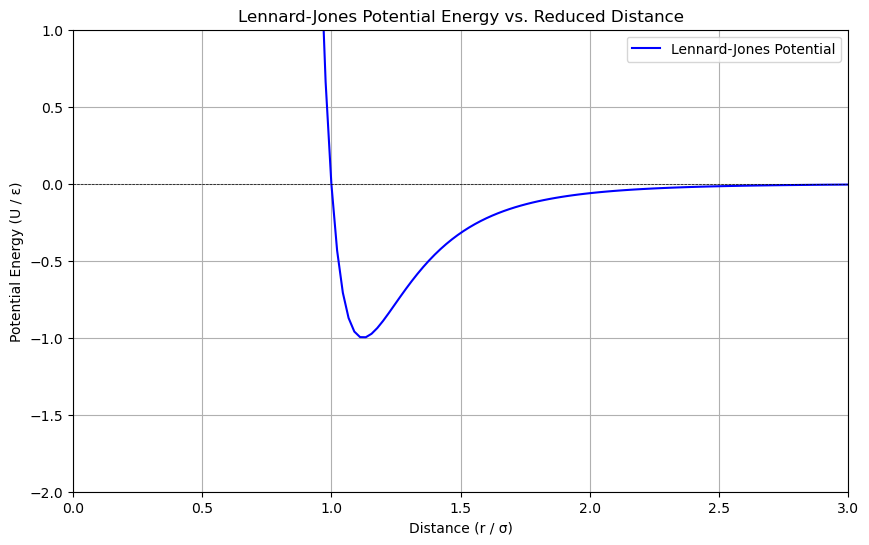

In [266]:
# Lennard-Jones potential calculation
def lj_potential(r):
    """Calculate Lennard-Jones potential for distance r."""
    return 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

# Generate a range of distances
r_values = np.linspace(0.8 *sigma, 3.0  *sigma, 100)  # Avoid r = 0 to prevent singularity
energy_values = lj_potential(r_values)

# Normalize by epsilon and convert distances to reduced units (r/sigma)
r_reduced = r_values / sigma
energy_reduced = energy_values / epsilon

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(r_reduced, energy_reduced, label='Lennard-Jones Potential', color='blue')
plt.title('Lennard-Jones Potential Energy vs. Reduced Distance')
plt.xlabel('Distance (r / σ)')
plt.ylabel('Potential Energy (U / ε)')
plt.axhline(0, color='black', lw=0.5, ls='--')  # Add a horizontal line at U = 0
plt.xlim(0, 3)
plt.ylim(-2, 1)  # Adjust limits for better visualization
plt.grid()
plt.legend()
plt.savefig("Lennard-Jones Potential Energy.png")
plt.show()

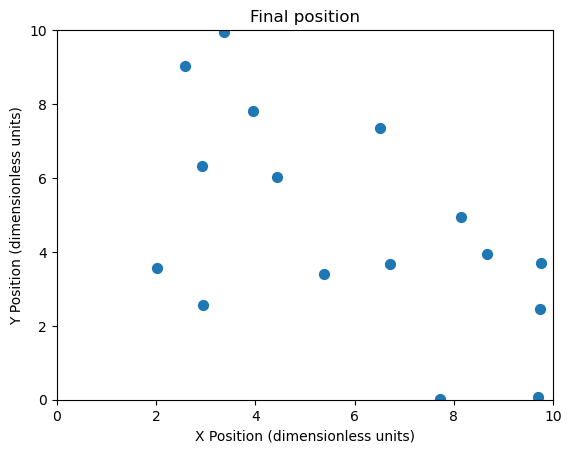

In [267]:
# Visualization of particle last position
fig, ax = plt.subplots()
ax.set_xlim(0, BOX_SIZE)
ax.set_ylim(0, BOX_SIZE)
scat = ax.scatter(positions[:, 0], positions[:, 1], s=50)

plt.title("Final position")
plt.xlabel("X Position (dimensionless units)")
plt.ylabel("Y Position (dimensionless units)")
plt.savefig("place of particles at final time.png")
plt.show()

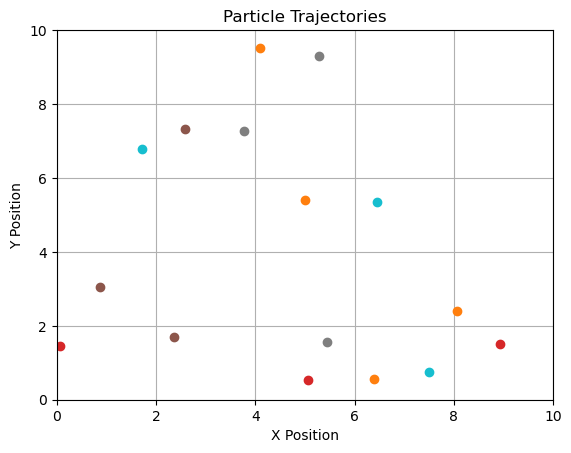

In [281]:
# Position vs Time plot

trajectories = np.zeros((STEPS, N_PARTICLES, 2))

for step in range(STEPS):
    #positions, velocities = update_positions_and_velocities(positions, velocities)
    trajectories[step] = positions

# Plotting the trajectories
fig, ax = plt.subplots()
ax.set_xlim(0, BOX_SIZE)
ax.set_ylim(0, BOX_SIZE)

# Plot the trajectories of each particle
for i in range(N_PARTICLES):
    ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], alpha=0.5)  # Plot the path
    ax.plot(trajectories[-1, i, 0], trajectories[-1, i, 1], 'o')  # Plot the final position

plt.title('Particle Trajectories')
plt.xlabel('X Position')
plt.ylabel('Y Position')  
plt.grid()
plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4

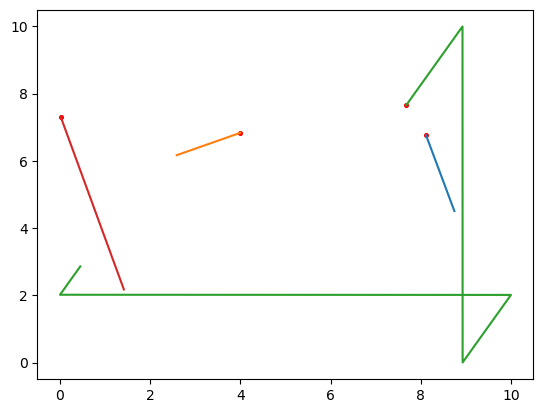

In [240]:
# Position vs Time plot
def plot_position_vs_time(positions_history):
    fig, ax = plt.subplots()

    for i in range(N_PARTICLES):
        x_positions = [pos[i][0] for pos in positions_history]
        y_positions = [pos[i][1] for pos in positions_history]

        ax.plot(x_positions, y_positions, label=f'Particle {i+1}')
        
        # Plot the last position of each particle
        ax.scatter(x_positions[-1], y_positions[-1], color='red', s=7, zorder=1)  # Red dot for the last position

    ax.set_title('Particle Positions Over Time')
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    
    # Set legend position to the right of the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust the position as needed
    ax.grid()
    
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.savefig("particle_trajectory.png")
    plt.show()

plot_position_vs_time(positions_history)
